In [23]:
import pandas as pd
import os
from rdflib import Graph, Namespace
from collections import defaultdict
from tqdm.notebook import tqdm
import json

VIOLATION_LIST_FILE = "./json/violation_list.json" # path to store the violation list
STUDY_CSV_FILE = "./csv/study.csv" # path to store the tabluraized study csv file
STUDY_TTL_PATH = './ttl/study.ttl' # contains the actual study data
OMICS_MODEL_TTL_PATH = './ttl/omics_model.ttl' # contains the ontology
VIOLATION_REPORT_TTL_PATH = './ttl/violation_report.ttl' # contains the shacl violation test case result


In [24]:
print("Reading study graph...")
study_graph = Graph()
study_graph.parse(STUDY_TTL_PATH, format="ttl")

print("Reading violations graph...")
violations_graph = Graph()
violations_graph.parse(VIOLATION_REPORT_TTL_PATH, format="ttl")

Reading study graph...
Reading violations graph...


<Graph identifier=Ndea4ff7260d24b049bc382c3f15c40ec (<class 'rdflib.graph.Graph'>)>

In [25]:
from rdflib import Graph, Namespace
from rdflib.namespace import NamespaceManager

def tabularize_graphs(study: Graph, violations: Graph):
    """
    Converts two RDF graphs (study graph and violations graph) into a tabular format (pandas DataFrame),
    using the subjects (focus nodes) of the study graph as indices. The columns of the DataFrame include
    both the properties of the study graph and the violation types (source shapes) from the violations graph.
    The resulting DataFrame includes information about each focus node from the study graph and counts the 
    number of times each focus node violates each source shape.

    The DataFrame and a list of unique violation types are then saved to disk.

    Parameters:
    study (Graph): An RDF graph representing the study, where each triple represents a property of a focus node.
    violations (Graph): An RDF graph representing the violations, where each triple represents a focus node's 
    violation of a source shape.

    Returns:
    None, but saves DataFrame and list of unique violation types to disk.
    """

    
    SH = Namespace("http://www.w3.org/ns/shacl#")

    # Create a dictionary to hold violation counts for each focusNode-sourceShape pair
    violation_counts = defaultdict(lambda: defaultdict(int))
    current_focus_node = None
    violation_list = []

    for s, p, o in tqdm(sorted(violations, key=lambda x: str(x[0])), desc="Processing violations"):  # sorting triples based on subject
        if p == SH.focusNode:
            current_focus_node = str(o)
        elif current_focus_node and p == SH.sourceShape:
            violation_list += [str(o)]
            violation_counts[current_focus_node][str(o)] += 1

    violation_list = list(set(violation_list))
    
    # Save violation_list to a JSON file
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)  

    # Initialize study DataFrame with indices as focusNodes and columns as sourceShapes
    study_df = pd.DataFrame(violation_counts).T.fillna(0)

    for s, p, o in tqdm(study, desc="Processing study"):
        if str(s) in study_df.index:
            if str(p) not in study_df.columns:
                study_df[str(p)] = ""
            study_df.at[str(s), str(p)] = str(o)

    # After creating your DataFrame and before saving to csv, just add the following line:
    study_df['focus_node'] = study_df.index

    study_df.to_csv(STUDY_CSV_FILE)

tabularize_graphs(study_graph, violations_graph)

study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()

Processing violations:   0%|          | 0/286592 [00:00<?, ?it/s]

Processing study:   0%|          | 0/97794 [00:00<?, ?it/s]

,http://data.boehringer.com/ontology/omics/ece15faa-30b3-471c-ae51-2d6d1f80e3a9,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isPreparedByLibrary,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasStrandedness,http://data.boehringer.com/ontology/omics/9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,http://data.boehringer.com/ontology/omics/38c0a1c7-1c92-489a-a22e-87f5335ccb1a,http://data.boehringer.com/ontology/omics/afb51f95-5b17-45a4-b62d-c58f4998f930,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isMeasuredOnPlatform,http://data.boehringer.com/ontology/omics/248e9792-8549-4e0d-8665-06c42aff8ffc,http://data.boehringer.com/ontology/omics/0c2600b5-30b2-40c7-917a-b402e73f55ae,http://data.boehringer.com/ontology/omics/af998a22-f11b-43ea-b0ac-44e728baeafb,...,http://data.boehringer.com/ontology/omics/hasStudyType,http://data.boehringer.com/ontology/omics/hasContactCompBio,http://data.boehringer.com/ontology/omics/sourceStudyId,http://data.boehringer.com/ontology/omics/isSequencedForTherapeuticArea,http://data.boehringer.com/ontology/omics/externalStudyId,http://data.boehringer.com/ontology/omics/studyDescription,http://data.boehringer.com/ontology/omics/technicalStudyTitle,http://data.boehringer.com/ontology/omics/studyId,http://data.boehringer.com/ontology/omics/hasResponsibleSite,focus_node
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_1652,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_959,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/b88ad57b-08d3-4b45-99f5-1864c80d1f10,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/5bb9c5e6-f245-4bcf-a6f3-213a079d434e,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/802f9bb2-1f46-457b-aef5-3273caaa9c57,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...


In [26]:
import pandas as pd
from rdflib import Graph
from rdflib.namespace import split_uri

def namespace_in_nsm(nsm, namespace):
    """
    Checks if a given namespace is in the provided NamespaceManager.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to check
    namespace (str): the namespace to look for in the NamespaceManager

    Returns:
    bool: True if the namespace is in the NamespaceManager, False otherwise
    """
    for prefix, ns in nsm.namespaces():
        if str(ns) == str(namespace):
            return True
    return False

def get_qname(nsm, uri):
    """
    Returns a QName for a given URI if its namespace is in the provided NamespaceManager.
    If the namespace isn't found in the NamespaceManager, it returns the original URI.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to use
    uri (str): the URI to transform into a QName

    Returns:
    str: a QName if the namespace of the URI is in the NamespaceManager, the original URI otherwise
    """
    namespace, name = split_uri(uri)
    if namespace_in_nsm(nsm, namespace):
        try:
            prefix, _, _ = nsm.compute_qname(uri)
            return f"{prefix}:{name}"
        except Exception as e:
            return uri
    else:
        return uri

def abbreviate_using_namespaces(study_graph: Graph, violations_graph: Graph):
    """
    Replaces URIs in a DataFrame and a list of violations with QNames if their namespaces
    are found in two provided RDF graphs. Saves the updated DataFrame and the list back to disk.

    Parameters:
    study_graph (Graph): the first RDF graph to use for namespaces
    violations_graph (Graph): the second RDF graph to use for namespaces
    """

    # load violation_list
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_list = json.load(f)

    # read study_df tabularized data
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    # Create a new graph to combine namespaces
    combined_graph = Graph()

    # Get namespaces from both graphs and bind them to the combined graph
    for prefix, ns_uri in study_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    for prefix, ns_uri in violations_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    # Now use the NamespaceManager of the combined graph
    nsm_combined = NamespaceManager(combined_graph)

    # Change column names
    for col in study_df.columns:
        try:
            study_df.rename(columns={col: get_qname(nsm_combined, col)}, inplace=True)
        except:
            pass

    # Change indices and cell values
    for col in study_df.columns:
        for idx in study_df.index:
            try:
                study_df.loc[idx, col] = get_qname(nsm_combined, study_df.loc[idx, col])
            except:
                pass

    # change index
    for idx in study_df.index:
        try:
            study_df.rename(index={idx: get_qname(nsm_combined, str(idx))}, inplace=True)
        except:
            pass

    # change violation_list
    for i in range(len(violation_list)):
        try:
            violation_list[i] = get_qname(nsm_combined, violation_list[i])
        except:
            pass

    # store tabular graph as csv
    study_df.to_csv(STUDY_CSV_FILE)    

    # store violation_list as json
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)

abbreviate_using_namespaces(study_graph, violations_graph)

In [27]:
with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_list = json.load(f)

print('unique violations ('+str(len(violation_list))+'):\n')
print('\n'.join([str(v) for v in violation_list]))

unique violations (18):

omics:OmicsStudyShape-hasContactCompBio
omics:OmicsStudyShape-isPartOfProject
omics:OmicsStudyShape-hasResponsibleSite
omics:38c0a1c7-1c92-489a-a22e-87f5335ccb1a
omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f
omics:TranscriptOmicsSampleShape-isPreparedByLibrary
omics:TranscriptOmicsSampleShape-hasSequencingProtocol
omics:OmicsStudyShape-isSequencedForIndication
omics:248e9792-8549-4e0d-8665-06c42aff8ffc
omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9
omics:TranscriptOmicsSampleShape-hasStrandedness
omics:0c2600b5-30b2-40c7-917a-b402e73f55ae
omics:af998a22-f11b-43ea-b0ac-44e728baeafb
omics:OmicsStudyShape-hasContactScientist
omics:OmicsStudyShape-isSequencedForTherapeuticArea
omics:OmicsStudyShape-hasStudyType
omics:afb51f95-5b17-45a4-b62d-c58f4998f930
omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform


In [28]:
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()

,omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9,omics:TranscriptOmicsSampleShape-isPreparedByLibrary,omics:TranscriptOmicsSampleShape-hasStrandedness,omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,omics:38c0a1c7-1c92-489a-a22e-87f5335ccb1a,omics:afb51f95-5b17-45a4-b62d-c58f4998f930,omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform,omics:248e9792-8549-4e0d-8665-06c42aff8ffc,omics:0c2600b5-30b2-40c7-917a-b402e73f55ae,omics:af998a22-f11b-43ea-b0ac-44e728baeafb,...,omics:hasStudyType,omics:hasContactCompBio,omics:sourceStudyId,omics:isSequencedForTherapeuticArea,omics:externalStudyId,omics:studyDescription,omics:technicalStudyTitle,omics:studyId,omics:hasResponsibleSite,focus_node
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_1652,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_959,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/b88ad57b-08d3-4b45-99f5-1864c80d1f10,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/5bb9c5e6-f245-4bcf-a6f3-213a079d434e,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/802f9bb2-1f46-457b-aef5-3273caaa9c57,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...


Creating UMAP embedding... (this may take some time)
UMAP(n_neighbors=69, random_state=0, verbose=True)
Fri Jun 23 11:27:13 2023 Construct fuzzy simplicial set
Fri Jun 23 11:27:13 2023 Finding Nearest Neighbors
Fri Jun 23 11:27:13 2023 Building RP forest with 8 trees
Fri Jun 23 11:27:13 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
Fri Jun 23 11:27:14 2023 Finished Nearest Neighbor Search
Fri Jun 23 11:27:14 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jun 23 11:27:46 2023 Finished embedding
UMAP embedding created and saved to ./csv/study.csv


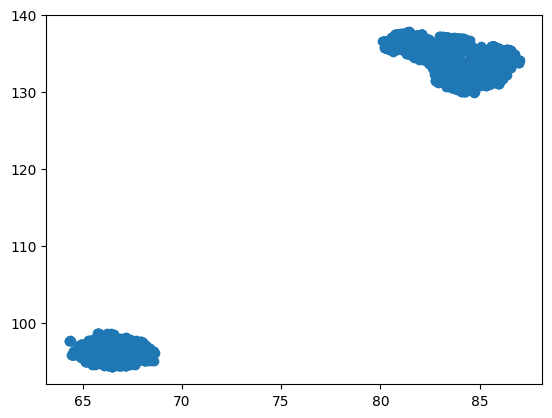

In [29]:
from matplotlib import pyplot as plt
import umap
import pandas as pd
import json
import numpy as np

def create_embedding():
    # read study.csv
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
    
    # read violation_list.json
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_columns = json.load(f)
    
    view_df = study_df[violation_columns] # view of study dataframe with only violation columns

    print("Creating UMAP embedding... (this may take some time)")
    reducer = umap.UMAP(n_neighbors=int(np.sqrt(len(view_df))), min_dist=0.1, n_components=2, random_state=0, verbose=True)
    embedding = reducer.fit_transform(view_df) # 2D projection

    study_df["x"] = embedding[:, 0]
    study_df["y"] = embedding[:, 1]

    study_df.to_csv(STUDY_CSV_FILE)
    print("UMAP embedding created and saved to", STUDY_CSV_FILE)
    

def plot_embedding():
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    plt.scatter(study_df["x"], study_df["y"])
    plt.show()

create_embedding()
plot_embedding()


In [30]:
# TODO process ontology to differentiate between nan values: relation cannot exist given ontology, or relation is actually missing. also potentially that there is a relation when there shouldn't be but that would me more difficult to handle in the data afterwards

In [34]:
import pandas as pd
import json
from rdflib import URIRef

label_predicate = URIRef('http://www.w3.org/2004/02/skos/core#prefLabel')

# read tabularized graph .csv as a dataframe, and violations list .json as a list
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_columns = json.load(f)

# create a dictionary of {s: o} pairs for translating source shapes to their labels
label_dict = {str(s): str(o) for s, p, o in study_graph.triples((None, label_predicate, None))}

# Create a new graph to combine namespaces
combined_graph = Graph()

# Get namespaces from both graphs and bind them to the combined graph
for prefix, ns_uri in study_graph.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(prefix, ns_uri)

for prefix, ns_uri in violations_graph.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(prefix, ns_uri)

# Now use the NamespaceManager of the combined graph
nsm_combined = NamespaceManager(combined_graph)

# replace the label_dict keys with their corresponding QNames
label_dict = {get_qname(nsm_combined, k): v for k, v in label_dict.items()}


# replace all column names, indices, and cell values in the dataframe with their corresponding labels
study_df.columns = [label_dict.get(col, col) for col in study_df.columns]
study_df.index = pd.Index([label_dict.get(idx, idx) for idx in study_df.index])
for col in study_df.columns:
    study_df[col] = study_df[col].apply(lambda x: label_dict.get(x, x))

# replace all dictionary keys and values with their corresponding labels
violation_columns = [label_dict.get(x, x) for x in violation_columns]

# store dataframe back to .csv and violations list back to .json
study_df.to_csv(STUDY_CSV_FILE)
with open(VIOLATION_LIST_FILE, 'w') as f:
    json.dump(violation_columns, f)

In [35]:
label_dict

{'http://vocabulary.boehringer.com/OMICS/d3e43a12-403d-4299-95a5-7e3dbe50918a': 'Stefan Pflanz',
 'http://vocabulary.boehringer.com/OMICS/67ecb0ea-0b44-4357-9af7-131d787d87bc': 'HiSeq2500',
 'http://vocabulary.boehringer.com/OMICS/4ddc9bf7-73bd-45de-aa78-ad3ccfc24420': 'scRNA-seq',
 'http://vocabulary.boehringer.com/OMICS/07e0e9f3-9564-4f58-b36b-a3affa14a356': 'ex vivo',
 'http://vocabulary.boehringer.com/OMICS/14884101-7675-49ca-b50c-32da5aeb965a': 'Primary cells',
 'http://vocabulary.boehringer.com/OMICS/6f2a8408-2031-471a-bd42-5d1f4564cf6a': 'unknown',
 'http://vocabulary.boehringer.com/OMICS/ac828eb0-cb7b-4f5b-866e-197bcf7a8e32': 'polyA RNA',
 'http://vocabulary.boehringer.com/OMICS/fe0dd6cf-162c-4c04-bf13-9986eb8f1f85': 'Boehringer Ingelheim, Biberach, Germany',
 'http://vocabulary.boehringer.com/OMICS/bb2440ad-e80e-424d-ad29-fc83a277611b': 'Baerbel Laemmle',
 'http://vocabulary.boehringer.com/OMICS/12eec321-ca7e-4866-982f-0a0677fed966': 'FACS sorted biological material',
 'http:/

In [32]:
violation_columns

['omics:OmicsStudyShape-hasContactCompBio',
 'omics:OmicsStudyShape-isPartOfProject',
 'omics:OmicsStudyShape-hasResponsibleSite',
 'omics:38c0a1c7-1c92-489a-a22e-87f5335ccb1a',
 'omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f',
 'omics:TranscriptOmicsSampleShape-isPreparedByLibrary',
 'omics:TranscriptOmicsSampleShape-hasSequencingProtocol',
 'omics:OmicsStudyShape-isSequencedForIndication',
 'omics:248e9792-8549-4e0d-8665-06c42aff8ffc',
 'omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9',
 'omics:TranscriptOmicsSampleShape-hasStrandedness',
 'omics:0c2600b5-30b2-40c7-917a-b402e73f55ae',
 'omics:af998a22-f11b-43ea-b0ac-44e728baeafb',
 'omics:OmicsStudyShape-hasContactScientist',
 'omics:OmicsStudyShape-isSequencedForTherapeuticArea',
 'omics:OmicsStudyShape-hasStudyType',
 'omics:afb51f95-5b17-45a4-b62d-c58f4998f930',
 'omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform']